# Criando um sistema de recomendação para um site de e-commerce

Fonte dos dados:

https://www.kaggle.com/datasets/carrie1/ecommerce-data?resource=download

https://www.kaggle.com/admond1994/e-commerce-data-eda/notebook

### Informações gerais sobre os dados
* Dataset disponibilizado no site Kaggle
* Empresa de varejo online com base no Reino Unido 
* O produto comercializado é principalmente composto de presentes / lembranças para todas as ocasiões
* O principal tipo de cliente são atacadistas (locais e internacionais)
* Período de transações analisado: 01/12/2010 a 09/12/2011 (aproximadamente 1 ano)

## 1. Carregando e fazendo uma limpeza preliminar do dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

import gc
import datetime

%matplotlib inline
plt.style.use('ggplot')

In [2]:
df = pd.read_csv("./ecommerce_data.csv", encoding='ISO-8859-1')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [4]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


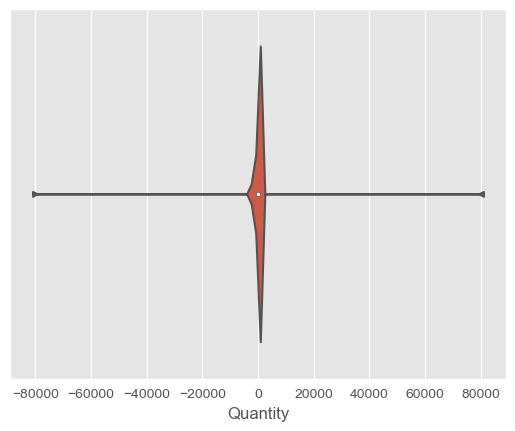

In [5]:
ax = sns.violinplot(x=df["Quantity"])

É possível observar que, por algum motivo, temos valores negativos no campo de Quantity (já que o valor de min está como -80995). Como neste caso não é possível um cliente comprar uma quantidade negativa de produtos, pode ser que este valor tenha sido provido de um erro de digitação, porém não é possível assegurar isso. Por isso, decidi por remover todas as linhas que constam uma quantidade e preço unitário negativos.

In [6]:
#removendo valores negativos
df = df.loc[df['Quantity'] > 0]
df = df.loc[df['UnitPrice'] > 0]

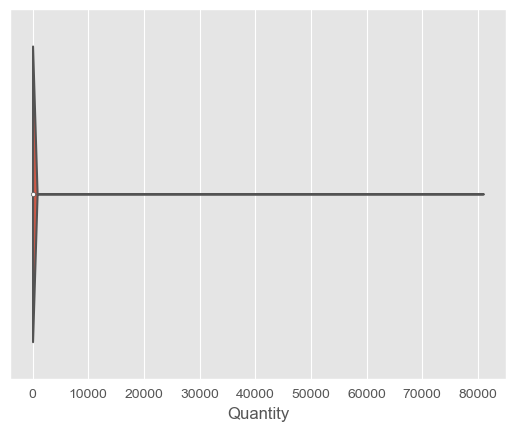

In [7]:
ax = sns.violinplot(x=df["Quantity"])

In [8]:
#Verificando se existem dados faltantes
df[df.isnull().any(axis=1)].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom


In [9]:
df.isnull().sum().sort_values(ascending=False)

CustomerID     132220
InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
Country             0
dtype: int64

É possível observar que, das 541909 linhas de dados, 135080 estão sem os valores de CustomerID (quase 25% do total!) e 1454 não possuem o campo Description.

In [10]:
#Criando um novo DataFrame sem os valores faltantes
df = df.dropna(subset=['CustomerID'])

In [11]:
#Verificando os valores faltantes para cada coluna
df.isnull().sum().sort_values(ascending=False)

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

## 2. Criando a matriz "Customer - Item Matrix"


In [14]:
print("Itens Únicos: \n", df.nunique())

Itens Únicos: 
 InvoiceNo      18532
StockCode       3665
Description     3877
Quantity         301
InvoiceDate    17282
UnitPrice        440
CustomerID      4338
Country           37
dtype: int64


Nesse caso, para a desenvolvimento do algorítmo de recomendação de produtos, deve-se criar uma matriz que contém o "CustomerID" como índice e uma coluna para cada item individual. 

![Costumer Item Matrix](https://thingsolver.com/wp-content/uploads/h6-1024x434.png)

Conforme foi verificado, este dataset contém <mark>3665 itens individuais</mark> e <mark>4338 clientes</mark>. Isso implica que a matriz "Customer - Item" deverá possuir 4338 linhas e 3665 colunas! 

In [15]:
customer_item_matrix = df.pivot_table(index="CustomerID", columns="StockCode", values="Quantity", aggfunc="sum")
customer_item_matrix.head()

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12348.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.0
12349.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
12350.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


In [19]:
customer_item_matrix.shape

(4338, 3665)

É possível observar que nesta matriz, caso o cliente comprou um item, a quantidade é mostrada na coluna do item específico e, caso o cliente não comprou o item, o valor NaN é mostrado. Para simplificar, irei substituir tudo o que é NaN por **"0"** e o restante por **"1"**.

![Customer Matrix 2](https://images.slideplayer.com/18/6109706/slides/slide_9.jpg)

In [18]:
customer_item_matrix = customer_item_matrix.applymap(lambda x: 1 if x > 0 else 0)
customer_item_matrix.head()

StockCode,10002,10080,10120,10123C,10124A,10124G,10125,10133,10135,11001,...,90214V,90214W,90214Y,90214Z,BANK CHARGES,C2,DOT,M,PADS,POST
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12347.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
12348.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12349.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12350.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


## 3. Criando o "Filtro Colaborativo" (User- Based Collaborative Filtering)

"Cosine Similarity" é uma medida de similaridade entre dois pontos de dados em um plano. A "similaridade de cosseno" é usada como métrica em diferentes algoritmos de Machine Learning como o KNN para determinar a distância entre os vizinhos. Em sistemas de recomendação, é usado para recomendar itens com as mesmas semelhanças e para dados textuais, é usado para encontrar a similaridade de textos no documento.

![Cosine Similarity](https://miro.medium.com/max/1400/1*JdXBbKlOKS9UNFpLNchfdA.png)

In [20]:
from sklearn.metrics.pairwise import cosine_similarity

## 4. User-to-User similarity matrix

Utilizando a função cosine_similarity, podemos traçar as similaridades entre os clientes presentes na matriz customer_item_matrix

In [22]:
user_user_sim_matrix = pd.DataFrame(cosine_similarity(customer_item_matrix))
user_user_sim_matrix.head()

,0,1,2,3,4,5,6,7,8,9,...,4328,4329,4330,4331,4332,4333,4334,4335,4336,4337
0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
1,0.0,1.000000,0.063022,0.046130,0.047795,0.038484,0.0,0.025876,0.136641,0.094742,...,0.0,0.029709,0.052668,0.0,0.032844,0.062318,0.0,0.113776,0.109364,0.012828
2,0.0,0.063022,1.000000,0.024953,0.051709,0.027756,0.0,0.027995,0.118262,0.146427,...,0.0,0.064282,0.113961,0.0,0.000000,0.000000,0.0,0.000000,0.170905,0.083269
3,0.0,0.046130,0.024953,1.000000,0.056773,0.137137,0.0,0.030737,0.032461,0.144692,...,0.0,0.105868,0.000000,0.0,0.039014,0.000000,0.0,0.067574,0.137124,0.030475
4,0.0,0.047795,0.051709,0.056773,1.000000,0.031575,0.0,0.000000,0.000000,0.033315,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.044866,0.000000


In [24]:
# trocando os nomes das colunas e linhas pelo CustomerID, para ficar mais fácil de entender

user_user_sim_matrix.columns = customer_item_matrix.index

user_user_sim_matrix['CustomerID'] = customer_item_matrix.index

user_user_sim_matrix = user_user_sim_matrix.set_index('CustomerID')
user_user_sim_matrix.head()


CustomerID,12346.0,12347.0,12348.0,12349.0,12350.0,12352.0,12353.0,12354.0,12355.0,12356.0,...,18273.0,18274.0,18276.0,18277.0,18278.0,18280.0,18281.0,18282.0,18283.0,18287.0
CustomerID,,,,,,,,,,,,,,,,,,,,,
12346.0,1.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000
12347.0,0.0,1.000000,0.063022,0.046130,0.047795,0.038484,0.0,0.025876,0.136641,0.094742,...,0.0,0.029709,0.052668,0.0,0.032844,0.062318,0.0,0.113776,0.109364,0.012828
12348.0,0.0,0.063022,1.000000,0.024953,0.051709,0.027756,0.0,0.027995,0.118262,0.146427,...,0.0,0.064282,0.113961,0.0,0.000000,0.000000,0.0,0.000000,0.170905,0.083269
12349.0,0.0,0.046130,0.024953,1.000000,0.056773,0.137137,0.0,0.030737,0.032461,0.144692,...,0.0,0.105868,0.000000,0.0,0.039014,0.000000,0.0,0.067574,0.137124,0.030475
12350.0,0.0,0.047795,0.051709,0.056773,1.000000,0.031575,0.0,0.000000,0.000000,0.033315,...,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,0.044866,0.000000


In [48]:
print(user_user_sim_matrix.sample)

<bound method NDFrame.sample of CustomerID  12346.0   12347.0   12348.0   12349.0   12350.0   12352.0  \
CustomerID                                                              
12346.0         1.0  0.000000  0.000000  0.000000  0.000000  0.000000   
12347.0         0.0  1.000000  0.063022  0.046130  0.047795  0.038484   
12348.0         0.0  0.063022  1.000000  0.024953  0.051709  0.027756   
12349.0         0.0  0.046130  0.024953  1.000000  0.056773  0.137137   
12350.0         0.0  0.047795  0.051709  0.056773  1.000000  0.031575   
...             ...       ...       ...       ...       ...       ...   
18280.0         0.0  0.062318  0.000000  0.000000  0.000000  0.000000   
18281.0         0.0  0.000000  0.000000  0.000000  0.000000  0.000000   
18282.0         0.0  0.113776  0.000000  0.067574  0.000000  0.037582   
18283.0         0.0  0.109364  0.170905  0.137124  0.044866  0.080278   
18287.0         0.0  0.012828  0.083269  0.030475  0.000000  0.033898   

CustomerID  12353.

# 5. Testando o sistema de recomendação 

Aqui, tentarei achar qual o cliente com os gostos mais similares ao cliente1 (escolhido aleatoriamente)

In [61]:
import random
random.seed(19)
cliente1 = random.choice(list(user_user_sim_matrix.index.values.tolist()))
print(cliente2)

12790.0


In [62]:
#achando o cliente mais similar ao cliente cujo CustomerID é 354
user_user_sim_matrix.loc[cliente1].sort_values(ascending=False)

CustomerID
12790.0    1.000000
16696.0    0.494872
15206.0    0.377964
16366.0    0.308607
13260.0    0.308607
             ...   
14908.0    0.000000
14910.0    0.000000
14913.0    0.000000
14915.0    0.000000
18287.0    0.000000
Name: 12790.0, Length: 4338, dtype: float64

Nesse caso, o cliente mais similar ao cliente1 (CustomerID 12790) é com cliente CustomerID 16696 com 49.5% de similaridade!

## Quais itens o cliente1 (CustomerID 12790) compra?

4338